In [ ]:
#!kaggle competitions download -c cassava-disease
# !ls data/
# !unzip test.zip -d data
# !unzip train.zip -d data

## After downloading

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import math
import pandas as pd
import os
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# import packages for the model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
from keras.utils import np_utils
from sklearn import preprocessing

print(os.listdir("../data"))


['train.zip', 'train', 'test.zip', 'extraimages.zip', 'extraimages', 'sample_submission_file.csv', '__MACOSX', 'test']


In [2]:
train_path = '../data/train/*/*.jpg' 
test_path = '../data/test/0/*.jpg' 
train_files = glob(train_path)
test_files = glob(test_path)

In [20]:
train_images = []
train_label = []
for img in train_files:
    train_images.append(cv2.resize(cv2.imread(img), (128,128)))
    train_label.append(img.split('/')[-2])

train_images = np.asarray(train_images)
train_label = pd.DataFrame(train_label)


test_images = []
test_label = []
for img1 in test_files:
    test_images.append(cv2.resize(cv2.imread(img1), (128,128)))
    test_label.append(img.split('/')[-2])
test_images = np.asarray(test_images)
test_label = pd.DataFrame(test_label)



The type of train images is: <class 'tuple'>
The shape of train images is: (5656, 128, 128, 3)
The type of train labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of train labels is:', (5656, 1))
The type of test images is: <class 'tuple'>
The shape of test images is: (3774, 128, 128, 3)
The type of test labels is: <class 'pandas.core.frame.DataFrame'>
('The shape of test labels is:', (3774, 1))


Some sample  images from the data set

In [22]:
train_images = train_images/255
test_images = test_images/255

In [23]:


label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label[0])
print("The different species of plants are: " + str(label_encoder.classes_))
encoded_train_labels = label_encoder.transform(train_label[0])

#Convert it to categorical encoders of 0s and 1s
encoded_train_labels = np_utils.to_categorical(encoded_train_labels)
num_clases = encoded_train_labels.shape[1]
print("The total plant categories are: " + str(num_clases))

The different species of plants are: ['cbb' 'cbsd' 'cgm' 'cmd' 'healthy']
The total plant categories are: 5


In [24]:
#Creating the training and validation splits:
from sklearn.model_selection import train_test_split
seed = 42
trainX, validationX, trainY, validationY = train_test_split(train_images, encoded_train_labels, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = encoded_train_labels)

In [25]:
print(trainX.shape)
print(trainY.shape)
print(validationX.shape)
print(validationY.shape)

(5090, 128, 128, 3)
(5090, 5)
(566, 128, 128, 3)
(566, 5)


In [26]:
## Model is taken from https://github.com/karen2565/cnn/sample
class CassavaNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [27]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [28]:

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score


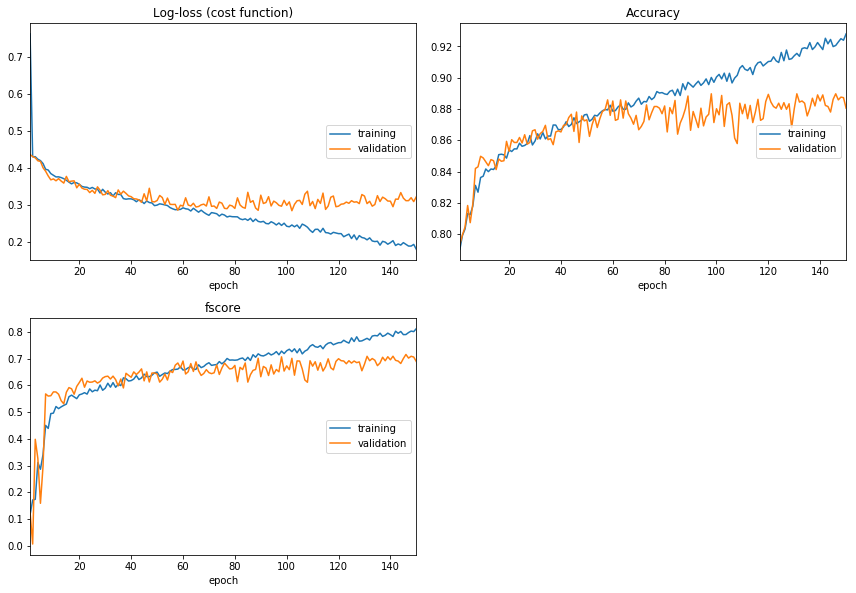

Log-loss (cost function):
training   (min:    0.181, max:    0.763, cur:    0.181)
validation (min:    0.285, max:    0.437, cur:    0.323)

Accuracy:
training   (min:    0.790, max:    0.928, cur:    0.928)
validation (min:    0.794, max:    0.890, cur:    0.881)

fscore:
training   (min:    0.117, max:    0.812, cur:    0.812)
validation (min:    0.007, max:    0.715, cur:    0.689)


In [29]:


EPOCHS = 150
INIT_LR = 1e-3
BS = 128

# initialize the model
print("[INFO] compiling model...")
model = CassavaNet.build(width=128, height=128, depth=3, classes=5)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy",fscore])
model_checkpoint = ModelCheckpoint('my_weights.h5', monitor='val_loss', save_best_only=True)
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(validationX, validationY), steps_per_epoch=len(trainX) // BS, callbacks=[model_checkpoint,PlotLossesCallback()],
	epochs=EPOCHS, verbose=1)

In [30]:
model.load_weights("my_weights.h5")

In [31]:
test_file_names = []
for file in glob(test_path):
    test_file_names.append(file.split('/')[-1])

#print(test_file_names)

In [35]:
preditions = model.predict(test_images)
prediction_class_Index = np.argmax(preditions, axis=1)
prediction_class = label_encoder.classes_[prediction_class_Index]
sumbit = {'Id': test_file_names, 'Category': prediction_class}

sumbit = pd.DataFrame(sumbit)
sumbit.to_csv("sumbit.csv", index=False)
print(sumbit.head(5))

                  Id Category
0  test-img-3648.jpg      cgm
1  test-img-2008.jpg     cbsd
2   test-img-334.jpg  healthy
3   test-img-493.jpg      cmd
4    test-img-79.jpg      cmd


In [36]:


#Submit the csv
print('Submitting csv .....')
!kaggle competitions submit cassava-disease -f sumbit.csv -m "M check"

print('\nSubmittion Done Bye')

Submitting csv .....
100%|██████████████████████████████████████| 81.6k/81.6k [00:01<00:00, 70.3kB/s]
Successfully submitted to Cassava Disease Classification 
Submittion Done Bye
